In [ ]:
# coded by Sayan Chandra CS20M057
# CS6910_DEEP LEARNING : (prof.) Mitesh M. Khapra

In [ ]:
import matplotlib.pyplot as plt
from keras.datasets import fashion_mnist, mnist
import numpy as np
from copy import deepcopy as clone

In [ ]:
# load dataset
def loadData():
    (trainX, trainy), (testX, testy) = fashion_mnist.load_data()
    N_inputs, dim_x_inp, dim_y_inp=len(trainX), len(trainX[0]), len(trainX[0][0])
    inputs=np.zeros((N_inputs, dim_x_inp*dim_y_inp))
    sum1=np.zeros((dim_x_inp*dim_y_inp))
    for i in range(N_inputs):
       inputs[i]=trainX[i].flatten()
       sum1+=inputs[i]
    mean1=sum1/N_inputs
    dim_inp=inputs.shape[1]

    sum2=np.zeros((dim_x_inp*dim_y_inp))
    testx=np.zeros((len(testX), dim_x_inp*dim_y_inp))
    for i in range(len(testX)):
      testx[i]=testX[i].flatten()
      sum2+=testx[i]
    mean2=sum2/len(testX)

    for i in range(N_inputs):
      inputs[i]-=mean1
      inputs[i]/=255
    trainx=inputs

    for i in range(len(testX)):
      testx[i]-=mean2
      testx[i]/=255
    return (trainx[6000: ], trainy[6000:], trainx[:6000], trainy[:6000], testx, testy)


In [ ]:
trainx, trainy, valx, valy, testx, testy=loadData()
dim_inp=trainx.shape[1]

In [ ]:
def Plottttt(x,y, strr):
  plt.plot([0,1,2,3,4],x,label='crossentropy')
  plt.plot([0,1,2,3,4],y,label='squarederror')
  plt.legend()
  plt.title(strr)
  plt.xlabel("epochs")
  plt.ylabel("accuracy")
  plt.show()

In [ ]:


## main variables inputs matrix, N_inputs, dim_inp

class MLSN (object): ## Multi layer Sigmoid Neurons
  def __init__(self, szInp, hiddenL, numOp, actvfunc, initfunc, lossfunc, lmda, vx, vy, xtest, ytest) :## size of inp, num of hidden layers, num of neurons per layer, num of output.
    self.szInp=szInp
    self.hiddenL=hiddenL
    self.numOp=numOp
    self.actvfunc=actvfunc
    self.initfunc=initfunc
    self.lossfunc=lossfunc
    self.lmda=lmda
    self.vx=vx
    self.vy=vy
    self.xtest=xtest
    self.ytest=ytest
    
    self.genericLayer=[szInp]+hiddenL+[numOp]
    print(self.genericLayer)
    self.lastpreactv=[]

    
    self.weights = []

    if self.initfunc=="random":
      for i in range(len(self.genericLayer) - 1):
        w = np.random.random((self.genericLayer[i], self.genericLayer[i + 1]))
        (self.weights).append(w)
    elif self.initfunc=="xavier":
      for i in range(len(self.genericLayer) - 1):
        w = np.random.normal(0, 1/np.sqrt(self.genericLayer[i]), (self.genericLayer[i], self.genericLayer[i + 1]))
        (self.weights).append(w)

    

    self.biases=[]
    for i in range(len(self.genericLayer) - 1):
      b = np.random.normal(0, 1, self.genericLayer[i + 1])
      (self.biases).append(b)


    self.prevWeights=[np.zeros(xx.shape) for xx in self.weights]
    self.prevBiases=[np.zeros(xx.shape) for xx in self.biases]


    self.activations = []
    for i in range(len(self.genericLayer)):
      a = np.zeros(self.genericLayer[i])
      (self.activations).append(a)


    self.delLdelA=clone(self.activations)
    self.delLdelH=clone(self.activations)
    

    self.delLdelW=clone(self.prevWeights)
    self.delLdelB=clone(self.prevBiases)

  def reinitdels(self):
    self.delLdelW=[np.zeros(xx.shape) for xx in self.weights]
    self.delLdelB=[np.zeros(xx.shape) for xx in self.biases]
    

  def calculate_a_i(self, i, w):
    return np.dot(i,w)

  sigmoid = lambda self, pa: np.array([(np.exp(term) if term<0 else 1)/(1+np.exp(term if term<0 else -term)) for term in pa])
  tanh = lambda self, pa: (np.exp(pa-np.max(pa))-np.exp(-pa-np.max(pa)))/(np.exp(pa-np.max(pa))+np.exp(-pa-np.max(pa)))
  reLU = lambda self, pa: np.maximum(0,pa*0.001)

  def calculate_h_i(self,pa):
    if self.actvfunc=="sigmoid" : return self.sigmoid(pa) 
    elif self.actvfunc=="tanh" :  return np.tanh(pa)
    elif self.actvfunc=="reLU" : return self.reLU(pa)+1e-8
    #return 1/(1+np.exp(-pa))

  def softmax(self,outpa):
    mx=np.max(outpa)
    outpa=outpa-mx
    return np.exp(outpa)/np.sum(np.exp(outpa)+1e-9)


  def feedFrwd(self,curinp,ws,bs):
    self.activations[0]=curinp
    for i in range(len(ws)-1):
      preActv=self.calculate_a_i(curinp, ws[i])+bs[i]
      actv=self.calculate_h_i(preActv)
      self.activations[i+1]=actv
      curinp=actv
    outPreActv=np.dot(curinp, ws[-1])+bs[-1]
    self.lastpreactv=clone(outPreActv)
    outActv=self.softmax(outPreActv)
    self.activations[-1]=outActv

  def derivativeActv(self, i):
    if self.actvfunc=="sigmoid" : return self.activations[i]*(1-self.activations[i])
    elif self.actvfunc=="tanh" : return 1-np.tanh(self.activations[i])**2
    elif self.actvfunc=="reLU" : 
      arrr= clone(self.activations[i])
      arrr[arrr>0]=1; arrr[arrr<=0]=0
      return arrr

  def crossentropy(self, curidx, ys):
    a=np.zeros(self.numOp)
    a[ys[curidx]]=1
    a=-(a-self.activations[-1])
    self.delLdelA[-1]=a

  def squarederror(self, curidx, ys):
    predclass=ys[curidx]
    pp=clone(self.lastpreactv)
    self.lastpreactv=np.exp(self.lastpreactv)
    pp=np.exp(pp)
    pp[predclass]=0
    add1, add2, add3=np.sum(pp), np.sum(pp**2), np.sum(self.lastpreactv)
    xyz = ((add3 * (self.lastpreactv + add1) - (add2 + add1**2) )/(add3**3))*pp
    xyz[predclass] = ( -1 * (add2 + add1**2)/(add3**3) ) *(self.lastpreactv[predclass])
    self.delLdelA[-1]=xyz


  def lossDerivative(self, curidx,  ys):
    if self.lossfunc=="crossentropy" : self.crossentropy(curidx, ys)
    elif self.lossfunc=="squarederror" : self.squarederror(curidx, ys)

  def backProp(self, curidx, ys):
    self.lossDerivative(curidx, ys)
    for i in range(len(self.genericLayer)-2,-1,-1):
      sz1=len(self.delLdelA[i+1])
      sz2=len(self.activations[i])
      self.delLdelW[i]+=np.matmul(self.delLdelA[i+1].reshape(sz1,1),self.activations[i].reshape(sz2,1).T).T + self.lmda*self.weights[i]
      self.delLdelH[i]=np.dot(self.weights[i], self.delLdelA[i+1])
      self.delLdelA[i]=np.multiply(self.delLdelH[i], self.derivativeActv(i))
      self.delLdelB[i]+=self.delLdelA[i+1]


  def TrainAccuracy(self,data,lables):
    count=0
    curloss=0
    for i in range(len(data)):#
      curinp=data[i]#
      self.feedFrwd(curinp, self.weights, self.biases)
      count+=(np.argmax(self.activations[-1])==lables[i])
      if self.lossfunc=="crossentropy":
        curloss+=-np.log(max(self.activations[-1]))+(self.lmda/2)*np.sum([np.sum(w**2) for w in self.weights])
      if self.lossfunc=="squarederror":
        dummy=np.zeros(len(self.activations[-1]))
        dummy[lables[i]]=1
        curloss+=np.sum((self.activations[-1]-dummy)**2)
    return (count/len(data), curloss/len(data))

  def TestAccuracy(self,data,lables):
    count=0
    curloss=0
    predictions=[]
    for i in range(len(data)):#
      curinp=data[i]#
      self.feedFrwd(curinp, self.weights, self.biases)
      predictions.append(np.argmax(self.activations[-1]))
      count+=(np.argmax(self.activations[-1])==lables[i])
      curloss+=-np.log(max(self.activations[-1]))+(self.lmda/2)*np.sum([np.sum(w**2) for w in self.weights])

    return (count/len(data), curloss/len(data))




  def trainNADAM(self, xs, ys, run, batchsize, rate):
    beta1, beta2, eps=0.9, 0.9, 1e-7
    m_w=[np.zeros(xx.shape) for xx in self.delLdelW]
    m_b=[np.zeros(xx.shape) for xx in self.delLdelB]
    v_w=[np.zeros(xx.shape) for xx in self.delLdelW]
    v_b=[np.zeros(xx.shape) for xx in self.delLdelB]
    var=0
    for _ in range(run):
      var+=batchsize
      self.reinitdels()
      
      for i in range(len(xs)):
        curinp=xs[i]
        self.feedFrwd(curinp,self.weights, self.biases)
        self.backProp(i, ys)
        if i%(batchsize-1)==0 and i!=0:
          var+=1
          for j in range(len(self.weights)):

            m_w[j]=m_w[j]*beta1 + self.delLdelW[j]*(1-beta1)
            m_b[j]=m_b[j]*beta1 + self.delLdelB[j]*(1-beta1)

            v_w[j]=v_w[j]*beta2 + (self.delLdelW[j]**2)*(1-beta2)
            v_b[j]=v_b[j]*beta2 + (self.delLdelB[j]**2)*(1-beta2)
            
            if var>0:
              m_w[j]/=(1-np.power(beta1,var))
              m_b[j]/=(1-np.power(beta1,var))
              v_w[j]/=(1-np.power(beta2,var))+1e-7
              v_b[j]/=(1-np.power(beta2,var))+1e-7

            m_w[j]=m_w[j]*beta1 + self.delLdelW[j]*(1-beta1)
            m_b[j]=m_b[j]*beta1 + self.delLdelB[j]*(1-beta1)
            v_w[j]=v_w[j]*beta2 + (self.delLdelW[j]**2)*(1-beta2)
            v_b[j]=v_b[j]*beta2 + (self.delLdelB[j]**2)*(1-beta2)

            self.weights[j]-=m_w[j]*((rate/batchsize)/np.sqrt(v_w[j]+eps))
            self.biases[j]-=m_b[j]*((rate/batchsize)/np.sqrt(v_b[j]+eps))


          self.reinitdels()


      #print(self.TrainAccuracy(xs, ys))
      a,b=self.TrainAccuracy(xs, ys)
      c,d=self.TrainAccuracy(self.vx, self.vy)
      e,f=self.TestAccuracy(self.xtest, self.ytest)###########################################


  def trainADAM(self, xs, ys, run, batchsize, rate):
    beta1, beta2, eps=0.9, 0.9, 1e-8
    m_w=[np.zeros(xx.shape) for xx in self.delLdelW]
    m_b=[np.zeros(xx.shape) for xx in self.delLdelB]
    v_w=[np.zeros(xx.shape) for xx in self.delLdelW]
    v_b=[np.zeros(xx.shape) for xx in self.delLdelB]
    var=0
    for _ in range(run):
      var+=batchsize
      self.reinitdels()
      
      for i in range(len(xs)):
        curinp=xs[i]
        self.feedFrwd(curinp,self.weights, self.biases)
        self.backProp(i, ys)
        if i%(batchsize-1)==0 and i!=0:
          var+=1
          for j in range(len(self.weights)):
            m_w[j]=m_w[j]*beta1 + self.delLdelW[j]*(1-beta1)
            m_b[j]=m_b[j]*beta1 + self.delLdelB[j]*(1-beta1)

            v_w[j]=v_w[j]*beta2 + (self.delLdelW[j]**2)*(1-beta2)
            v_b[j]=v_b[j]*beta2 + (self.delLdelB[j]**2)*(1-beta2)
            
            if var:
              m_w[j]=np.divide(m_w[j],1-np.power(beta1,var))
              m_b[j]=np.divide(m_b[j],1-np.power(beta1,var))
              v_w[j]=np.divide(v_w[j],1-np.power(beta2,var))
              v_b[j]=np.divide(v_b[j],1-np.power(beta2,var))

            self.weights[j]-=((m_w[j]*(rate/batchsize))/np.sqrt(v_w[j]+eps))
            self.biases[j]-=((m_b[j]*(rate/batchsize))/np.sqrt(v_b[j]+eps))


          self.reinitdels()


      #print(self.TrainAccuracy(xs, ys))
      a,b=self.TrainAccuracy(xs, ys)
      c,d=self.TrainAccuracy(self.vx, self.vy)
      e,f=self.TestAccuracy(self.xtest, self.ytest)###########################################


  def trainRMSPROP(self, xs, ys, run, batchsize, rate):
    beta, eps=0.8, 1e-8
    w_s=[np.zeros(xx.shape) for xx in self.delLdelW]
    b_s=[np.zeros(xx.shape) for xx in self.delLdelB]
    for _ in range(run):
      
      self.reinitdels()
      
      for i in range(len(xs)):
        curinp=xs[i]
        self.feedFrwd(curinp,self.weights, self.biases)
        self.backProp(i, ys)
        if i%(batchsize-1)==0 and i!=0:
          for j in range(len(self.weights)):
            w_s[j]=w_s[j]*beta + (self.delLdelW[j]**2)*(1-beta)
            b_s[j]=b_s[j]*beta + (self.delLdelB[j]**2)*(1-beta)
            self.weights[j]=self.weights[j] - self.delLdelW[j]*((rate/batchsize)/np.sqrt(w_s[j]*eps))
            self.biases[j]=self.biases[j] - self.delLdelB[j]*((rate/batchsize)/np.sqrt(b_s[j]*eps))
          self.reinitdels()


      #print(self.TrainAccuracy(xs, ys))
      a,b=self.TrainAccuracy(xs, ys)
      c,d=self.TrainAccuracy(self.vx, self.vy)
      e,f=self.TestAccuracy(self.xtest, self.ytest)###########################################


  def trainNAGD(self, xs, ys, run, batchsize, rate):
    gamma=0.65
    for _ in range(run):
      self.reinitdels()
      wLA=[np.zeros(xx.shape) for xx in self.weights]
      bLA=[np.zeros(xx.shape) for xx in self.biases]
      self.prevWeights=[np.zeros(xx.shape) for xx in self.weights]
      self.prevBiases=[np.zeros(xx.shape) for xx in self.biases]

      for i in range(len(xs)):

        wLA=[self.weights[k]-self.prevWeights[k]*gamma for k in range (len(self.weights))] 
        bLA=[self.biases[k]-self.prevBiases[k]*gamma for k in range (len(self.biases))] 

        curinp=xs[i]
        self.feedFrwd(curinp, wLA, bLA)
        self.backProp(i, ys)
        if i%(batchsize-1)==0 and i!=0:
          for j in range(len(self.weights)):
            self.prevWeights[j]= self.prevWeights[j]*gamma+self.delLdelW[j]/batchsize*rate
            self.prevBiases[j]= self.prevBiases[j]*gamma+self.delLdelB[j]/batchsize*rate
            self.weights[j]-=self.prevWeights[j]
            self.biases[j]-=self.prevBiases[j]
          self.reinitdels()

      #print(self.TrainAccuracy(xs, ys))
      a,b=self.TrainAccuracy(xs, ys)
      c,d=self.TrainAccuracy(self.vx, self.vy)
      e,f=self.TestAccuracy(self.xtest, self.ytest)###########################################

  def trainMBGD(self, xs, ys, run, batchsize, rate):
    gamma=0.45
    for _ in range(run):
      self.reinitdels()

      for i in range(len(xs)):
        curinp=xs[i]
        self.feedFrwd(curinp,self.weights, self.biases)
        self.backProp(i, ys)
        if i%(batchsize-1)==0 and i!=0:
          for j in range(len(self.weights)):
            www= self.prevWeights[j]*gamma+self.delLdelW[j]/batchsize*rate
            bbb= self.prevBiases[j]*gamma+self.delLdelB[j]/batchsize*rate
            self.weights[j]-=www
            self.biases[j]-=bbb
            self.prevWeights[j]=www
            self.prevBiases[j]=bbb
          self.reinitdels()
      #print(self.TrainAccuracy(xs, ys))
      a,b=self.TrainAccuracy(xs, ys)
      c,d=self.TrainAccuracy(self.vx, self.vy)
      e,f=self.TestAccuracy(self.xtest, self.ytest)###########################################


  def trainGD(self, xs, ys, run, batchsize, rate):
    ttrn,vall,ttst=[],[],[]
    for _ in range(run):
      
      self.reinitdels()
      
      for i in range(len(xs)):
        curinp=xs[i]
        self.feedFrwd(curinp,self.weights, self.biases)
        self.backProp(i, ys)
        if i!=0 and (i%(batchsize-1) if batchsize!=1 else 0)==0:
          for j in range(len(self.weights)):
            self.weights[j]-=self.delLdelW[j]/batchsize*rate
            self.biases[j]-=self.delLdelB[j]/batchsize*rate
          self.reinitdels()

      #print(self.TrainAccuracy(xs, ys))
      a,b=self.TrainAccuracy(xs, ys)
      c,d=self.TrainAccuracy(self.vx, self.vy)
      e,f=self.TestAccuracy(self.xtest, self.ytest)###########################################
      ttrn.append(a); vall.append(c); ttst.append(e)
    return (ttrn, vall, ttst)

  def trainParent(self, xs, ys, strr, run, batchsize, rate):
    if strr=="SGD" : return self.trainGD(xs, ys, run, 1, rate)
    elif strr=="GD" : return self.trainGD(xs, ys, run, batchsize, rate)
    elif strr=="MBGD" : return self.trainMBGD(xs, ys, run, batchsize, rate)
    elif strr=="NAGD" : return self.trainNAGD(xs, ys, run, batchsize, rate)
    elif strr=="RMSPROP" : return self.trainRMSPROP(xs, ys, run, batchsize, rate)
    elif strr=="ADAM" : return self.trainADAM(xs, ys, run, batchsize, rate)
    elif strr=="NADAM" : return self.trainNADAM(xs, ys, run, batchsize, rate)


## main(){}//
obj=MLSN(dim_inp, [32], 10, "reLU", "xavier", "crossentropy", 0.0001, valx, valy, testx, testy)
a1,b1,c1=obj.trainParent(trainx,trainy, "GD", 5, 32, 3.1)
obj1=MLSN(dim_inp, [32], 10, "reLU", "xavier", "squarederror", 0.0001, valx, valy, testx, testy)
a2,b2,c2=obj1.trainParent(trainx,trainy, "GD", 5, 32, 3.1)

[784, 32, 10]
[784, 32, 10]


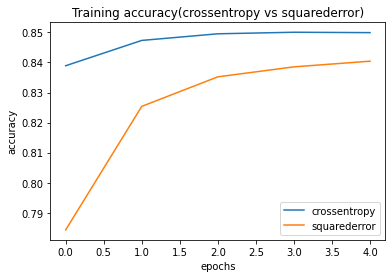

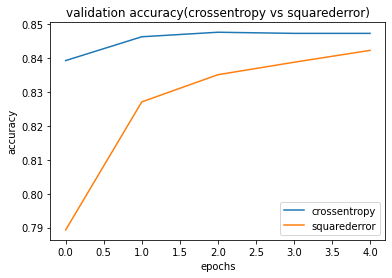

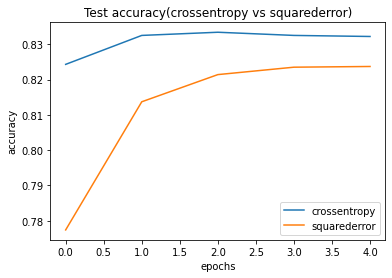

In [ ]:
Plottttt(a1, a2, "Training accuracy(crossentropy vs squarederror)")
Plottttt(b1, b2, "validation accuracy(crossentropy vs squarederror)")
Plottttt(c1, c2, "Test accuracy(crossentropy vs squarederror)")